## Preprocessing

In [1]:
# load the required modules

import os
import numpy as np
import pandas as pd
#from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
# sklearn stuff

# for random forest
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression


# metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# load the data
df = pd.read_csv('bookings_eda.csv', index_col=[0], parse_dates= ['reservation_status_date', 'arrival_date'])
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,region,nights_stayed,arrival_date,resv_time,arrival_season
0,Resort Hotel,0,342.0,0.0,0.0,2,0,0,BB,Portugal,...,0.0,0.0,0.0,Check-Out,2015-07-01,Europe,0.0,2015-07-01,0.0,summer
1,Resort Hotel,0,737.0,0.0,0.0,2,0,0,BB,Portugal,...,0.0,0.0,0.0,Check-Out,2015-07-01,Europe,0.0,2015-07-01,0.0,summer
2,Resort Hotel,0,7.0,0.0,1.0,1,0,0,BB,Other,...,75.0,0.0,0.0,Check-Out,2015-07-02,Europe,1.0,2015-07-01,1.0,summer
3,Resort Hotel,0,13.0,0.0,1.0,1,0,0,BB,Other,...,75.0,0.0,0.0,Check-Out,2015-07-02,Europe,1.0,2015-07-01,1.0,summer
4,Resort Hotel,0,14.0,0.0,2.0,2,0,0,BB,Other,...,98.0,0.0,1.0,Check-Out,2015-07-03,Europe,2.0,2015-07-01,2.0,summer


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119386 entries, 0 to 119385
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119386 non-null  object        
 1   is_canceled                     119386 non-null  int64         
 2   lead_time                       119386 non-null  float64       
 3   stays_in_weekend_nights         119386 non-null  float64       
 4   stays_in_week_nights            119386 non-null  float64       
 5   adults                          119386 non-null  int64         
 6   children                        119386 non-null  int64         
 7   babies                          119386 non-null  int64         
 8   meal                            119386 non-null  object        
 9   country                         119386 non-null  object        
 10  market_segment                  119386 non-null  object 

In [5]:
# cols to drop before modelling: 
# * reservation_status (it's basically the same as 'is_canceled', our target variable)
# * all the datetime columns (won't help in modelling)
# * also resv_time since that is for EDA purposes only! Plus it might skew the results
to_drop = ['reservation_status', 'reservation_status_date', 'arrival_date', 'resv_time']
df.drop(to_drop, axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119386 entries, 0 to 119385
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119386 non-null  object 
 1   is_canceled                     119386 non-null  int64  
 2   lead_time                       119386 non-null  float64
 3   stays_in_weekend_nights         119386 non-null  float64
 4   stays_in_week_nights            119386 non-null  float64
 5   adults                          119386 non-null  int64  
 6   children                        119386 non-null  int64  
 7   babies                          119386 non-null  int64  
 8   meal                            119386 non-null  object 
 9   country                         119386 non-null  object 
 10  market_segment                  119386 non-null  object 
 11  distribution_channel            119386 non-null  object 
 12  is_repeated_gues

In [7]:
# define X and y

y = df[['is_canceled']]
X = df.drop(['is_canceled'], axis=1)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=555)

**Initial 'Not-a-Model'**:
<br>
Just predict the most common occurance -- in this case, 0 (not cancelled).

In [8]:
from sklearn.dummy import DummyClassifier

dumb_class = DummyClassifier(strategy='most_frequent')
dumb_class.fit(X_train, y_train)
dumb_class.predict(X_train)

print(dumb_class.score(X_train, y_train))
print(dumb_class.score(X_test, y_test))

0.6285337353938937
0.6337632967585225


Dumb class has a 62.9% accuracy score on X_train... and 63.4% accuracy on X_test...

In [9]:
print("Classification Report for Training Data")
print(classification_report(y_train, dumb_class.predict(X_train)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     60030
           1       0.00      0.00      0.00     35478

    accuracy                           0.63     95508
   macro avg       0.31      0.50      0.39     95508
weighted avg       0.40      0.63      0.49     95508



C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
print("Classification Report for Test Data")
print(classification_report(y_test, dumb_class.predict(X_test)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.63      1.00      0.78     15133
           1       0.00      0.00      0.00      8745

    accuracy                           0.63     23878
   macro avg       0.32      0.50      0.39     23878
weighted avg       0.40      0.63      0.49     23878



C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dumb class seems do perform slightly better on test data...

**Logistic Regression with all features**

In [11]:
# logistic regression
# use OHE
df_ohe = pd.get_dummies(df, drop_first=False)
df_ohe.columns

Index(['is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'nights_stayed', 'hotel_City Hotel',
       'hotel_Resort Hotel', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'country_Other', 'country_Portugal',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Other', 'distribution_channel_Direct',
       'distribution_channel_Other', 'distribution_channel_TA/TO',
       'reserved_room_type_A', 'reserved_room_type_B', 'reserved_room_type_C',
       'reserved_room_type_D', 'reserved_room_type_E', 'reserved_room_type_F',
       'reserved_room_type_G', 'reserved_room_type_H', 'reserved

In [12]:
# define X and y for logistic reg

y = df_ohe[['is_canceled']]
X = df_ohe.drop(['is_canceled'], axis=1)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=247)

In [13]:
# sanity check
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(95508, 72) (95508, 1)
(23878, 72) (23878, 1)


*Fit and predict logistic regression*

In [14]:
# some hyperparams to play with later: solver, max_iter, C

#fit
# increased max_iter from 500 to 5000 b/c of an error
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(X_train, y_train) 

#predict
y_pred = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)

C:\Users\KNguyen\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*Score the logistic regression*

In [15]:
# compute accuracy on test data
print("[Test] Accuracy score (y_pred, y_test):",
      f'{accuracy_score(y_pred, y_test):.2f}')

# on train data
print("[Training] Accuracy score (y_pred_train, y_train):",
      f'{accuracy_score(y_pred_train, y_train):.2f}')

# 82% on Test, 81% on Train... interesting...

[Test] Accuracy score (y_pred, y_test): 0.82
[Training] Accuracy score (y_pred_train, y_train): 0.81


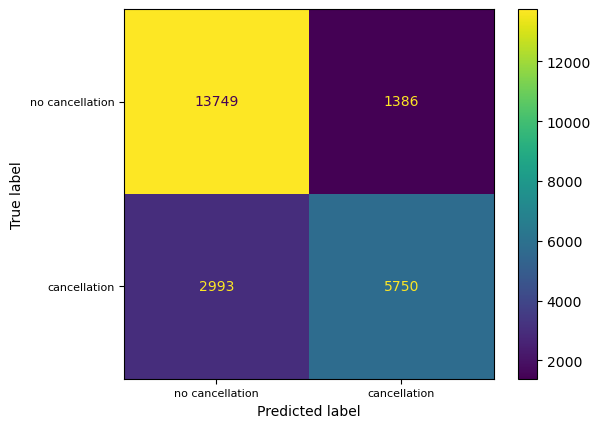

In [16]:
# correlation matrix on test set

cm = confusion_matrix(y_test, y_pred, labels = log_reg.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancellation', 'cancellation'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancellation', 'cancellation'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancellation', 'cancellation'], fontsize = 8)
display_cm.plot(ax = ax)


In [17]:
# classification report for training

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     60028
           1       0.81      0.65      0.72     35480

    accuracy                           0.81     95508
   macro avg       0.81      0.78      0.79     95508
weighted avg       0.81      0.81      0.81     95508



In [18]:
# classification report for test

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     15135
           1       0.81      0.66      0.72      8743

    accuracy                           0.82     23878
   macro avg       0.81      0.78      0.79     23878
weighted avg       0.82      0.82      0.81     23878



What's interesting is log_reg performed slightly better on the Test set than the Training set... 

This seems like a good model, but we will move on to Random Forest and compare them...

**Random Forest**

In [19]:
# prep the random forest...
# apparently link below says OHE makes rf worse, but .fit() method won't accept strings... 
# https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769

# train-test-split
# define X and y

y = df_ohe[['is_canceled']]
X = df_ohe.drop(['is_canceled'], axis=1)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

*Fit and predict random forest*

In [20]:
# hyperparams to play with later: n_estimators, criterion, max_depth(?), max_features(?)

# fit() does not accept strings -- must encode... 

rf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
rf_res = rf.fit(X_train, y_train)
y_pred = rf_res.predict(X_test)
y_pred_prob = rf_res.predict_proba(X_test)

# scores
lr_probs = y_pred_prob[:,1]
#lr_auc = roc_auc_score(y_test, lr_probs)
ac = accuracy_score(y_test, y_pred)
#lo = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
#print('Training Data Set 1 RandomForest: ROC AUC=%.3f' % (lr_auc))
print('Training Data Set 1 Random Forest: Accuracy=%.3f' % (ac))
#print('Training Data Set 1 Random Forest: Log loss=%.3f' % (lo))
print('Training Data Set 1 Random Forest: f1-score=%.3f' % (f1))

C:\Users\KNguyen\AppData\Local\Temp\ipykernel_12808\2614495562.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_res = rf.fit(X_train, y_train)


Training Data Set 1 Random Forest: Accuracy=0.887
Training Data Set 1 Random Forest: f1-score=0.886


*Confusion matrix for random forest*

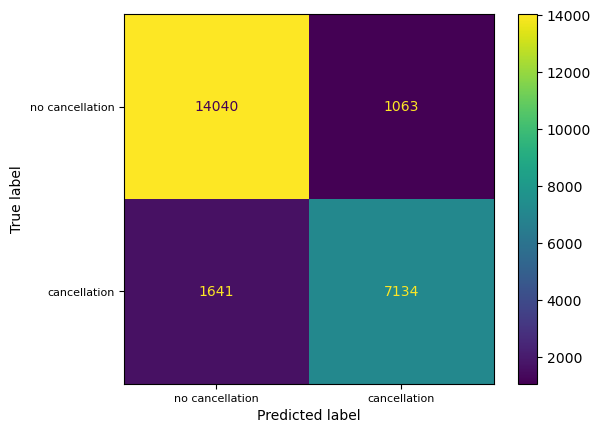

In [21]:
cm = confusion_matrix(y_test, y_pred, labels = rf_res.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancellation', 'cancellation'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancellation', 'cancellation'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancellation', 'cancellation'], fontsize = 8)
display_cm.plot(ax = ax)

Again, model performed slightly better on test set... are there bugs, or is this just a coincidence???

*Identify important features with Random Forest Classifier*

30


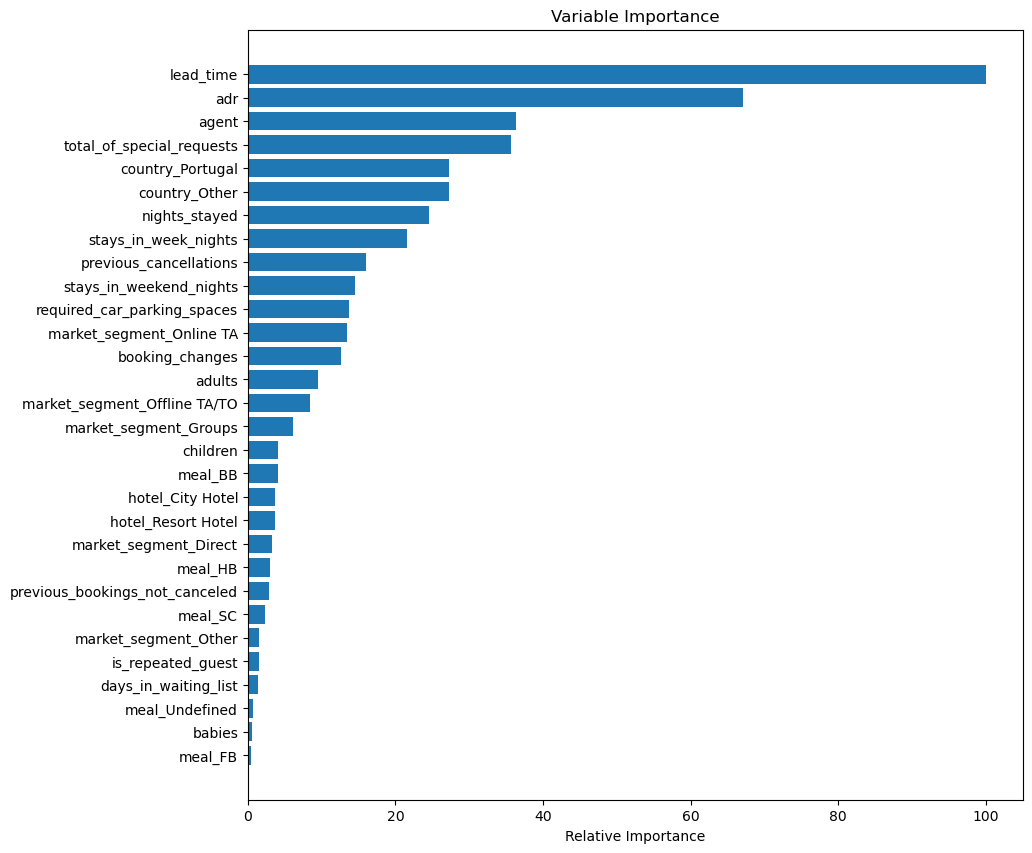

In [22]:
feature_importance = rf_res.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Lead time is the most important feature in predicting hotel cancellations, followed by adr. Whether the guests are local (from Portugal) or international do not seem to matter.
<br>
However, this article (https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769) says that one-hot-encoding may make feature importance less efficient. So maybe try label encoding?

As seen in the EDA part, a lot of the variables are highly correlated, so is there a simpler model that works?

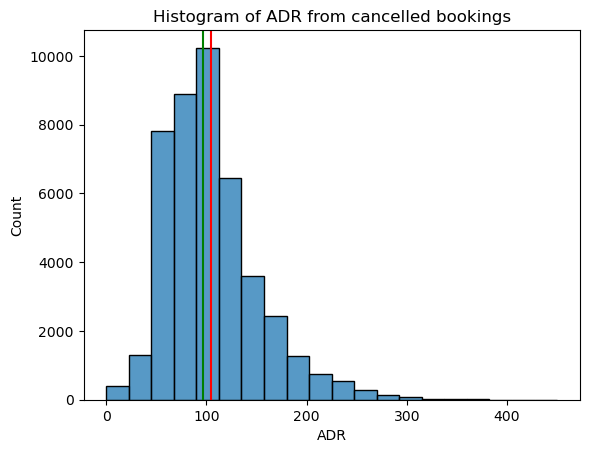

In [23]:
# look at ADR histogram
cxl = df[(df.is_canceled==1) & (df.adr<1000)]
h=sns.histplot(data=cxl, x='adr', bins=20)
h.set(xlabel ="ADR", ylabel = "Count", title ='Histogram of ADR from cancelled bookings')
h.axvline(x = cxl.adr.mean(), color = 'r', label = 'avg ADR')
h.axvline(x = cxl.adr.median(), color = 'g', label = 'median ADR')

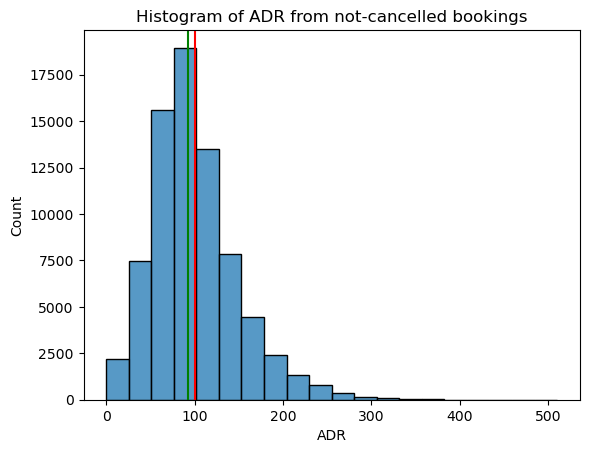

In [24]:
nocxl = df[(df.is_canceled==0) & (df.adr<1000)]
h=sns.histplot(data=nocxl, x='adr', bins=20)
h.set(xlabel ="ADR", ylabel = "Count", title ='Histogram of ADR from not-cancelled bookings')
h.axvline(x = nocxl.adr.mean(), color = 'r', label = 'avg ADR')
h.axvline(x = nocxl.adr.median(), color = 'g', label = 'median ADR')

interestingly, mean/median ADR is similar, regardless of cancellation status......